In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
from skill_label_classifier import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/edithzeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/edithzeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/edithzeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14505610208114955420
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10945105101
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1323489571692367545
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: f341:00:00.0, compute capability: 3.7"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# helper function to find optimal number of PC (elbow method)
def plot_explained_variance(X_train):
    pca = PCA()
    pca_full = pca.fit(X_train)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()
    
def preprocess_pca(X_train, X_test, dim, r=None):
    pca = PCA(n_components=dim, random_state=r)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

In [3]:
experiment = SkillClassifier()
experiment.import_data()
experiment.create_df()

experiment.choose_dataset('vqa')
experiment.set_features(['QSN', 'descriptions', 'tags', 'dominant_colors','handwritten_text', 'ocr_text'])
# experiment.set_features(['descriptions'])
experiment.set_targets()

features_train = experiment.features_train
features_val   = experiment.features_val

# check training class distribution
text_recognition_y_train = to_categorical(np.asarray(experiment.txt_train)).astype('float32')
color_recognition_y_train = to_categorical(np.asarray(experiment.col_train)).astype('float32')
print('Number of training samples each class: ')
print('Text recognition', text_recognition_y_train.sum(axis=0))
print('Color recognition', color_recognition_y_train.sum(axis=0))

n_classes = 2

# check validation class distribution
text_recognition_y_val = to_categorical(np.asarray(experiment.txt_val)).astype('float32')
color_recognition_y_val = to_categorical(np.asarray(experiment.col_val)).astype('float32')
print('Number of validation samples each class: ')
print('Text recognition', text_recognition_y_val.sum(axis=0))
print('Color recognition', color_recognition_y_val.sum(axis=0))

# get targets
txt_train      = experiment.txt_train
col_train      = experiment.col_train
txt_val        = experiment.txt_val
col_val        = experiment.col_val


Joined features with skill labels.
Joined features with skill labels.
Joined features with skill labels.
Joined features with skill labels.
VizWiz training shape: (14257, 13)
VQA training shape: (3230, 13)
Total training rows: 17487
VizWiz validation shape:(2247, 13)
VQA validation shape:(513, 13)
Total validation rows: 2760
Training: (3230, 13)
Validation: (513, 13)
Number of training samples each class: 
Text recognition [2872.  358.]
Color recognition [2082. 1148.]
Number of validation samples each class: 
Text recognition [450.  63.]
Color recognition [334. 179.]


In [4]:
# tokenize
tok        = Tokenizer(num_words=VOCAB_SIZE, 
                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                       lower=True,
                       split=" ")
tok.fit_on_texts(features_train)

# create sequences & pad
train_seq  = tok.texts_to_sequences(features_train)
train_seq  = sequence.pad_sequences(train_seq, maxlen=MAX_DOC_LEN)
val_seq    = tok.texts_to_sequences(features_val)
val_seq    = sequence.pad_sequences(val_seq, maxlen=MAX_DOC_LEN)

# Set validation data tuple
val_data = (val_seq, color_recognition_y_val)

# punkt sentence level tokenizer
sent_lst = [] 
for doc in features_train:
    sentences = nltk.tokenize.sent_tokenize(doc)
    for sent in sentences:
        word_lst = [w for w in nltk.tokenize.word_tokenize(sent) if w.isalnum()]
        sent_lst.append(word_lst)

# word2vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
word2vec_model = gensim.models.Word2Vec(sentences=sent_lst,
                                        min_count=6,
                                        size=EMBEDDING_DIM,
                                        sg=1,
                                        workers=os.cpu_count())

embeddings_index = {}
for word in word2vec_model.wv.vocab:
    coefs = np.asarray(word2vec_model.wv[word], dtype='float32')
    embeddings_index[word] = coefs
print('Total %s word vectors' % len(embeddings_index))

# Initial word embedding
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < VOCAB_SIZE:
        embedding_matrix[i] = embedding_vector

2019-03-17 23:41:56,380 : INFO : collecting all words and their counts
2019-03-17 23:41:56,381 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-17 23:41:56,402 : INFO : collected 4567 word types from a corpus of 129923 raw words and 3230 sentences
2019-03-17 23:41:56,403 : INFO : Loading a fresh vocabulary
2019-03-17 23:41:56,410 : INFO : effective_min_count=6 retains 845 unique words (18% of original 4567, drops 3722)
2019-03-17 23:41:56,411 : INFO : effective_min_count=6 leaves 124737 word corpus (96% of original 129923, drops 5186)
2019-03-17 23:41:56,416 : INFO : deleting the raw counts dictionary of 4567 items
2019-03-17 23:41:56,418 : INFO : sample=0.001 downsamples 76 most-common words
2019-03-17 23:41:56,418 : INFO : downsampling leaves estimated 79821 word corpus (64.0% of prior 124737)
2019-03-17 23:41:56,422 : INFO : estimated required memory for 845 words and 40 dimensions: 692900 bytes
2019-03-17 23:41:56,422 : INFO : resetting layer weigh

Total 845 word vectors


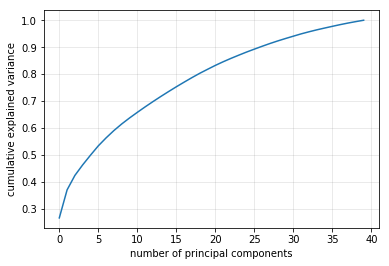

In [5]:
plot_explained_variance(train_seq)

In [6]:
N_COMPONENTS = 40
train_seq, val_seq = preprocess_pca(train_seq, val_seq, dim=N_COMPONENTS)

## VQA, 500 epochs, all features (no PCA)

In [ ]:
L = 1e-1
R = 0
B = 32
E = 500
skill='color'
vqa_color_result_500 = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/color/{}_{}_{}_{}_model.h5'.format(L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(txt_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

In [34]:
vqa_color_result = vqa_color_result_500.history
%store vqa_color_result

Stored 'vqa_color_result' (dict)


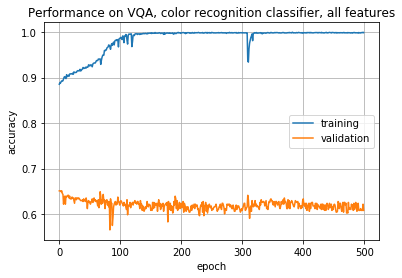

In [19]:
plt.plot([i for i in range(500)], vqa_color_result_500.history['acc'],label='training')
plt.plot([i for i in range(500)], vqa_color_result_500.history['val_acc'],label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Performance on VQA, color recognition classifier, all features")
plt.grid()
plt.legend()
plt.show()

## VQA, 500 epochs, full features, with PCA (40)

In [11]:
L = 1e-2
R = 1e-7
B = 32
E = 500
skill='color'
vqa_color_result_500 = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/color/{}_{}_{}_{}_model.h5'.format(L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(col_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

Learning rate: 0.01 Regularization: 1e-07 Batch size: 32 Epoch: 500
Accuracy = 0.6530214424951267 	 AUC = 0.5778835978835979


## VQA, 30 epochs, full features, with PCA (40)

In [15]:
L = 1e-2
R = 1e-7
B = 32
E = 40
skill='color'
vqa_color_result_40 = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/color/{}_{}_{}_{}_model.h5'.format(L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(col_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

Learning rate: 0.01 Regularization: 1e-07 Batch size: 32 Epoch: 40
Accuracy = 0.6510721247563352 	 AUC = 0.6095943562610229


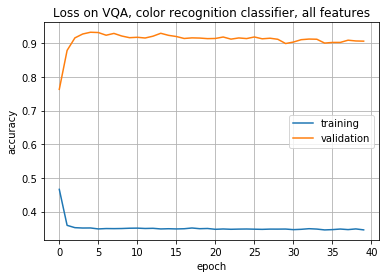

In [16]:
plt.plot([i for i in range(40)], vqa_color_result_40.history['loss'],label='training')
plt.plot([i for i in range(40)], vqa_color_result_40.history['val_loss'],label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Loss on VQA, color recognition classifier, all features")
plt.grid()
plt.legend()
plt.show()

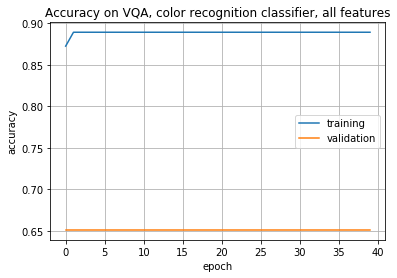

In [17]:
plt.plot([i for i in range(40)], vqa_color_result_40.history['acc'],label='training')
plt.plot([i for i in range(40)], vqa_color_result_40.history['val_acc'],label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy on VQA, color recognition classifier, all features")
plt.grid()
plt.legend()
plt.show()

In [18]:
# no significant change in loss and learning rate within 5 epochs
# need to readjust learning rate
L = 1e-1
R = 1e-7
B = 32
E = 40
skill='color'
vqa_color_result_40 = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/color/{}_{}_{}_{}_model.h5'.format(L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(col_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

Learning rate: 0.1 Regularization: 1e-07 Batch size: 32 Epoch: 40
Accuracy = 0.6510721247563352 	 AUC = 0.5939329805996473


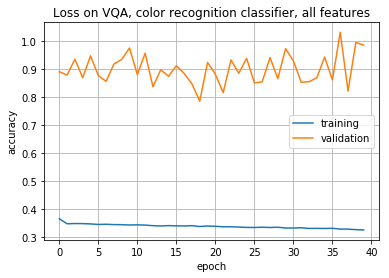

In [20]:
plt.plot([i for i in range(40)], vqa_color_result_40.history['loss'],label='training')
plt.plot([i for i in range(40)], vqa_color_result_40.history['val_loss'],label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Loss on VQA, color recognition classifier, all features")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# re-run after earlystopping, L2 norm and exponential learning schedule
L = 0.1
R = 1e-7
B = 64
E = 200
skill='color'
vqa_color_result_40 = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/color/{}_{}_{}_{}_model.h5'.format(L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(col_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

In [ ]:
plt.plot([i for i in range(200)], vqa_color_result_40.history['loss'],label='training')
plt.plot([i for i in range(200)], vqa_color_result_40.history['val_loss'],label='validation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on VQA, color recognition classifier, all features")
plt.grid()
plt.legend()
plt.show()